In [2]:
import geopandas as gpd
import momepy
from shapely.geometry import JOIN_STYLE,MultiPolygon, Polygon
import matplotlib.pyplot as plt
import libpysal
from shapely.ops import voronoi_diagram
from shapely.ops import unary_union
from shapely.geometry import JOIN_STYLE,MultiPolygon, Polygon
import matplotlib.pyplot as plt
import GeoTool

# 数据获取

In [3]:
# 读取边（街道轴线）
edges = gpd.read_file("road_network_cache/Nanjing_Yihe/Nanjing_Yihe_edges.shp").to_crs("EPSG:32650")
# 读取节点（交叉点）
nodes = gpd.read_file("road_network_cache/Nanjing_Yihe/Nanjing_Yihe_nodes.shp").to_crs("EPSG:32650")
# 读取POI（百度地图点）
pois = gpd.read_file("road_network_cache/Nanjing_Yihe/Nanjing_Yihe_poi_baidu.shp").to_crs("EPSG:32650")
# 读取Building（建筑地图）
buildings = gpd.read_file("road_network_cache/Nanjing_Yihe/Nanjing_Yihe_buildings.shp").to_crs("EPSG:32650")
print(edges)

print(pois)

                u            v  key       osmid    highway lanes  name  \
0        29571639   4226753211    0    52458715  secondary     2   山西路   
1        29571639   4631597350    0   142846710    primary     3  中山北路   
2        29571641   1038241973    0    62352731   tertiary  None  云南北路   
3        29571641   3311940056    0   142846710    primary     3  中山北路   
4        29571641   3239093499    0  1059174744   tertiary  None   云南路   
...           ...          ...  ...         ...        ...   ...   ...   
1231  11917400579  11917400574    0  1284584931    footway  None  None   
1232  11917400579  11917400581    0  1284584932    footway  None  None   
1233  11917400581  11917400569    0    91828923   tertiary  None   老菜市   
1234  11917400581  11917400577    0    91828923   tertiary  None   老菜市   
1235  11917400581  11917400579    0  1284584932    footway  None  None   

      oneway reversed      length service junction access maxspeed tunnel  \
0       True    False    8.189878 

# 计算地块获取

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 50N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


0      121052.111372
2       13141.104860
3       61179.413805
6       91016.088327
10      35046.419018
           ...      
185     23576.861965
186     17533.471535
191     17268.572330
192     15965.184026
197     15970.915281
Length: 86, dtype: float64


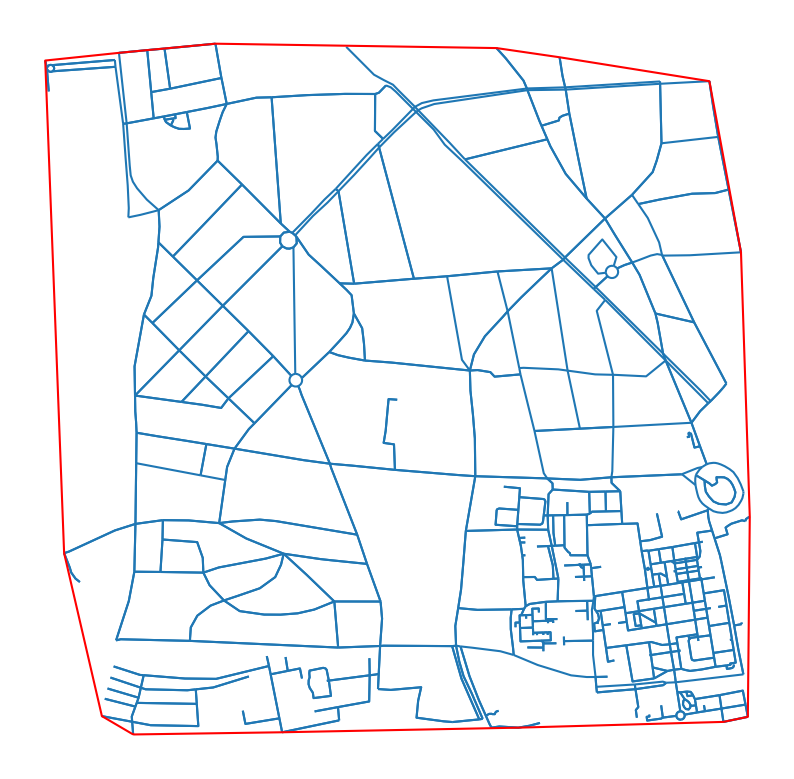

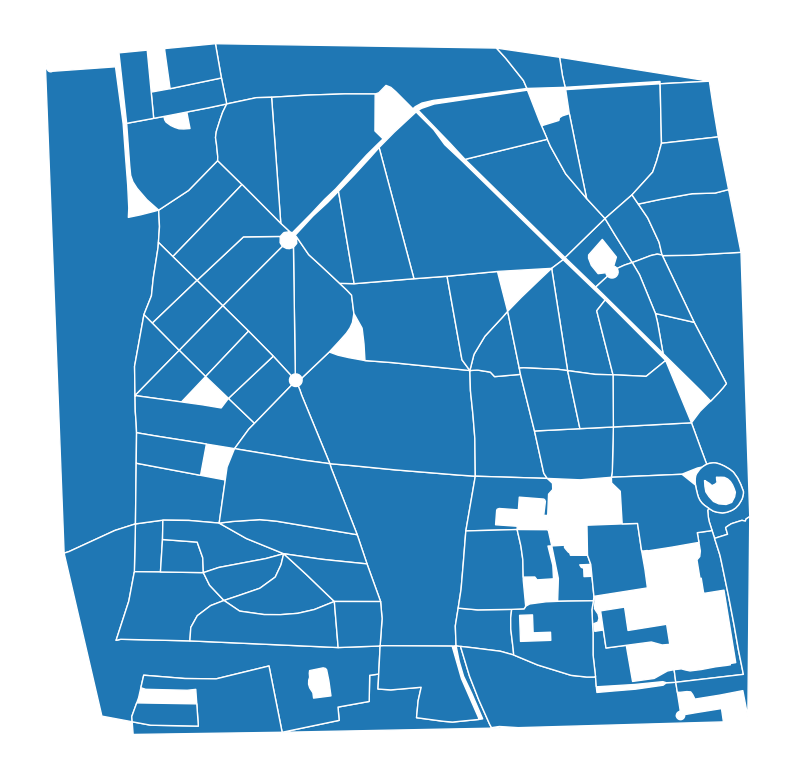

In [4]:
roads = edges.copy()
convex_hull = roads.union_all().convex_hull
enclosures = momepy.enclosures(roads, limit=convex_hull)
enclosures = enclosures[enclosures.area >10000]
ax = roads.plot(figsize=(10, 10))
hull =gpd.GeoDataFrame(geometry=[convex_hull.boundary],crs="EPSG:32650")
hull.plot(ax=ax, color="r")
ax.set_axis_off()
enclosures.plot(figsize=(10, 10), edgecolor="w").set_axis_off()
print(enclosures.area)

# 建筑数据预处理

0    LineString
dtype: object


<Axes: >

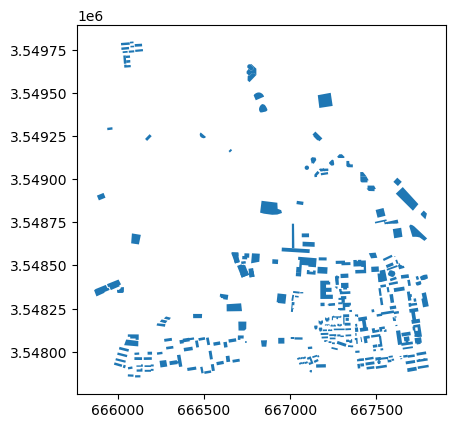

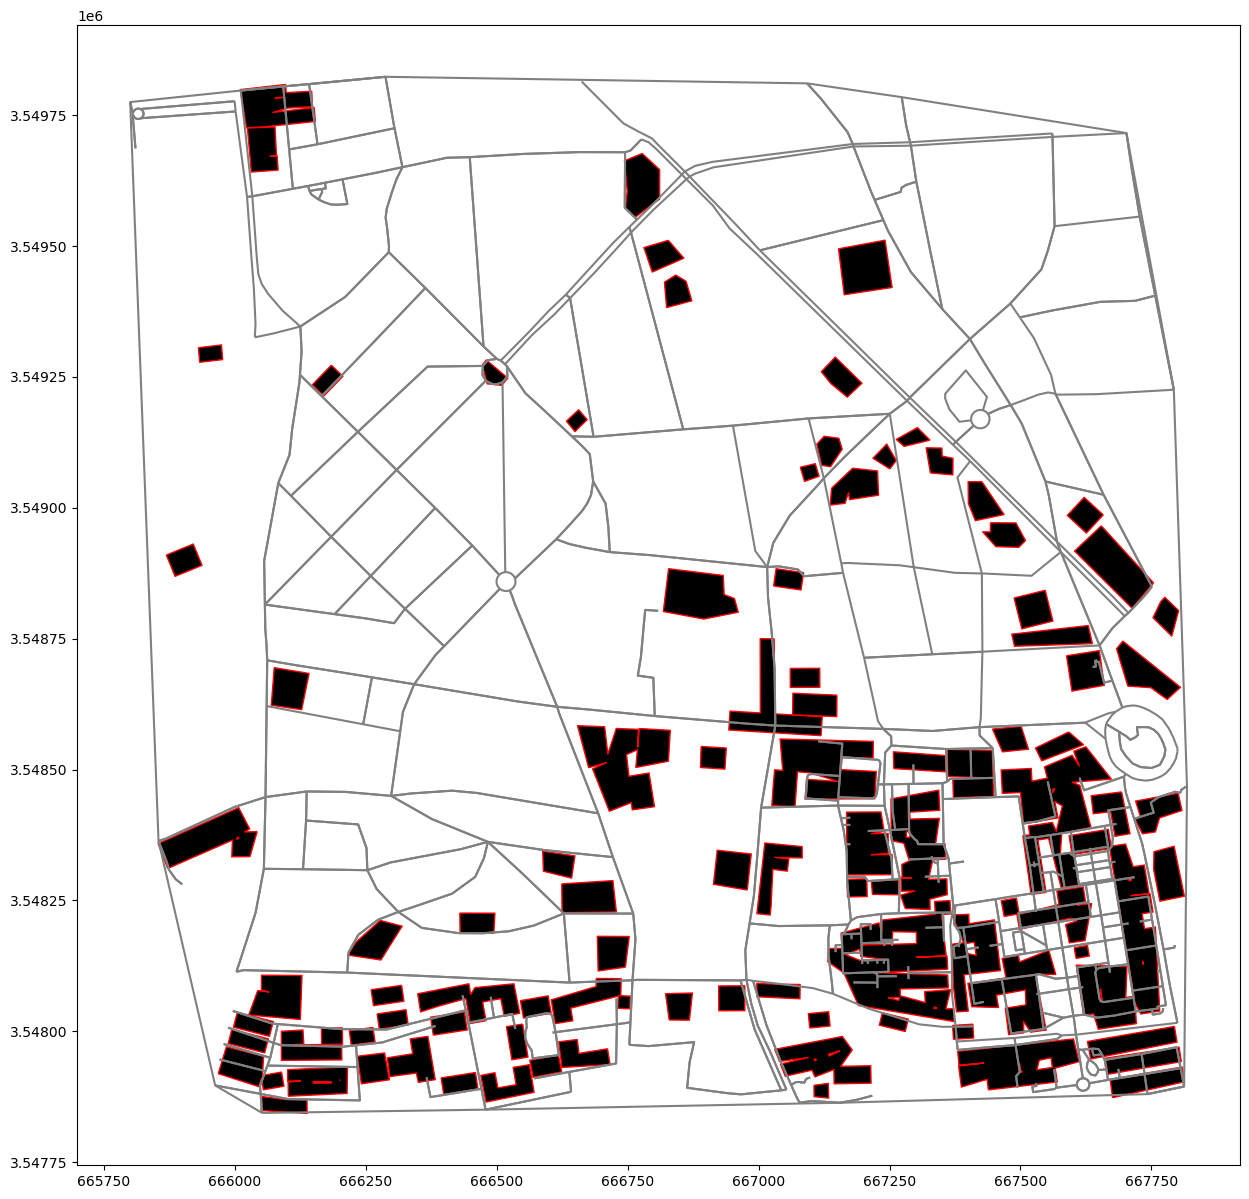

In [5]:

print(hull.type)
split_gdf,buildings_in_hull= GeoTool.create_split_gdf(buildings,convex_hull)
fig, ax = plt.subplots(figsize=(15, 15))
split_gdf.plot(ax=ax, color="black",edgecolor="red")
roads.plot(ax=ax, color="grey",)
hull.plot(ax=ax,color="grey")

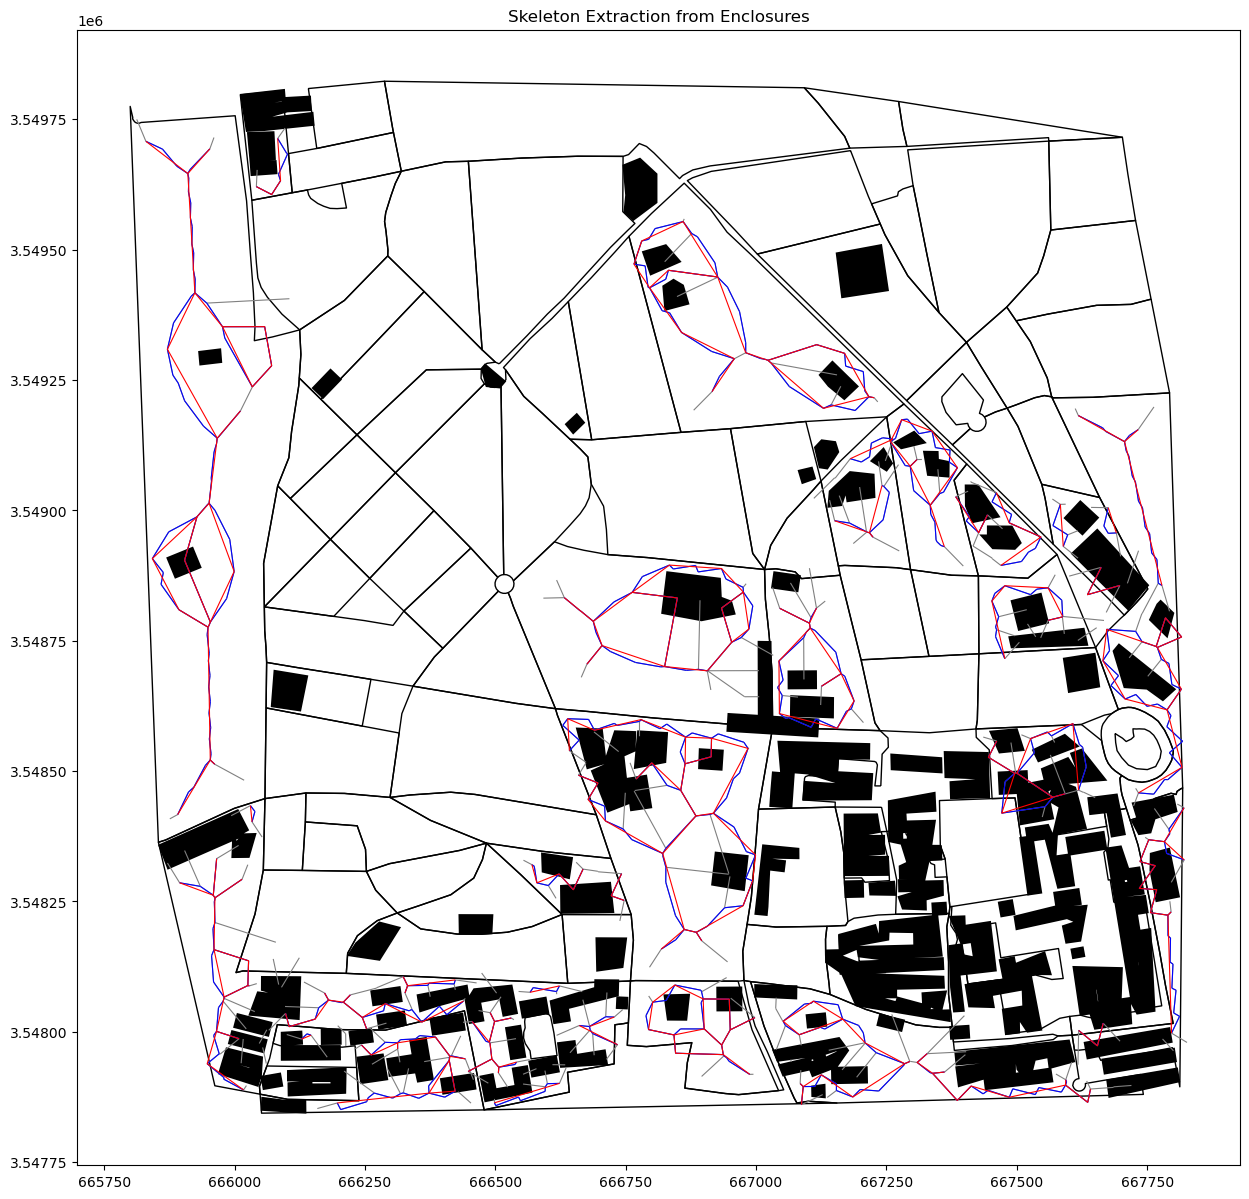

In [6]:
import GeoTool

skeleton_raw, skeleton_clean, skeleton_total = GeoTool.generate_skeletons_from_buildings(buildings=split_gdf, enclosures=enclosures,spacing=50,min_length=2,epsilon=20)


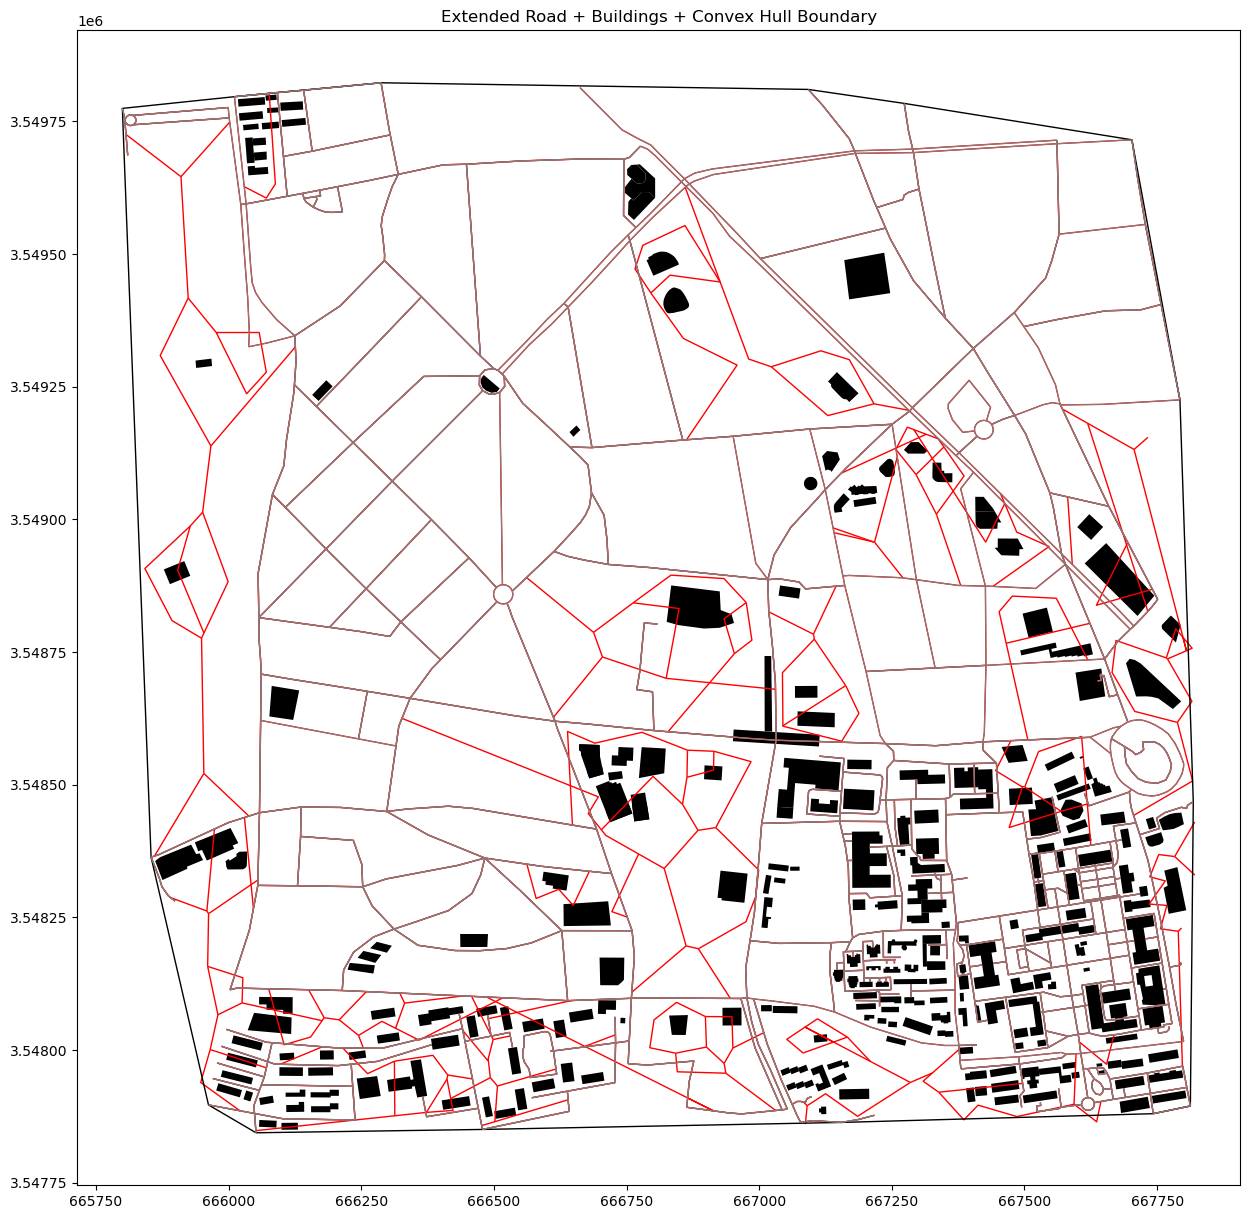

In [7]:
closed = GeoTool.plot_extended_road_closure(buildings_in_hull, roads, skeleton_total, enclosures, convex_hull)

In [8]:
print(closed)

               u             v  key       osmid    highway lanes  name oneway  \
0     29571639.0  4.226753e+09  0.0    52458715  secondary     2   山西路   True   
1     29571639.0  4.631597e+09  0.0   142846710    primary     3  中山北路   True   
2     29571641.0  1.038242e+09  0.0    62352731   tertiary  None  云南北路  False   
3     29571641.0  3.311940e+09  0.0   142846710    primary     3  中山北路   True   
4     29571641.0  3.239093e+09  0.0  1059174744   tertiary  None   云南路  False   
...          ...           ...  ...         ...        ...   ...   ...    ...   
1390         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   
1391         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   
1392         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   
1393         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   
1394         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   

     reversed      length s

# 合并三类 street

In [32]:
# 粗暴打标
roads["label"] = 1
hull["label"] = 1
closed["label"] = 0

In [33]:
from shapely.ops import snap
import pandas as pd

tolerance = 5
# 合并所有线段
combined = gpd.GeoDataFrame(pd.concat([roads, closed,hull]), crs=roads.crs)
lines = [
    part
    for geom in combined.geometry if geom is not None
    for part in (geom.geoms if geom.geom_type == 'MultiLineString' else [geom])
]
print(combined)
# 使用 linemerge 前，先 snap 所有线段首尾点，增强连接性
snapped_lines = []
for i in range(len(lines)):
    base = lines[i]
    for j in range(i + 1, len(lines)):
        base = snap(base, lines[j], tolerance)
    snapped_lines.append(base)

merged = GeoTool.safe_linemerge(snapped_lines)


               u             v  key       osmid    highway lanes  name oneway  \
0     29571639.0  4.226753e+09  0.0    52458715  secondary     2   山西路   True   
1     29571639.0  4.631597e+09  0.0   142846710    primary     3  中山北路   True   
2     29571641.0  1.038242e+09  0.0    62352731   tertiary  None  云南北路  False   
3     29571641.0  3.311940e+09  0.0   142846710    primary     3  中山北路   True   
4     29571641.0  3.239093e+09  0.0  1059174744   tertiary  None   云南路  False   
...          ...           ...  ...         ...        ...   ...   ...    ...   
1391         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   
1392         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   
1393         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   
1394         NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   
0            NaN           NaN  NaN         NaN        NaN   NaN   NaN    NaN   

     reversed      length s

                                               geometry  index_right  label  \
0     LINESTRING (665799.878 3549774.653, 665804.69 ...            0      1   
0     LINESTRING (665799.878 3549774.653, 665804.69 ...         1115      1   
0     LINESTRING (665799.878 3549774.653, 665804.69 ...         1140      1   
0     LINESTRING (665799.878 3549774.653, 665804.69 ...         1115      0   
0     LINESTRING (665799.878 3549774.653, 665804.69 ...         1140      0   
...                                                 ...          ...    ...   
2623  LINESTRING (667805.979 3547929.676, 667812.649...          481      1   
2623  LINESTRING (667805.979 3547929.676, 667812.649...          481      0   
2623  LINESTRING (667805.979 3547929.676, 667812.649...          826      0   
2623  LINESTRING (667805.979 3547929.676, 667812.649...          824      1   
2623  LINESTRING (667805.979 3547929.676, 667812.649...            0      1   

      dist  
0      0.0  
0      0.0  
0      0.0  

<Axes: >

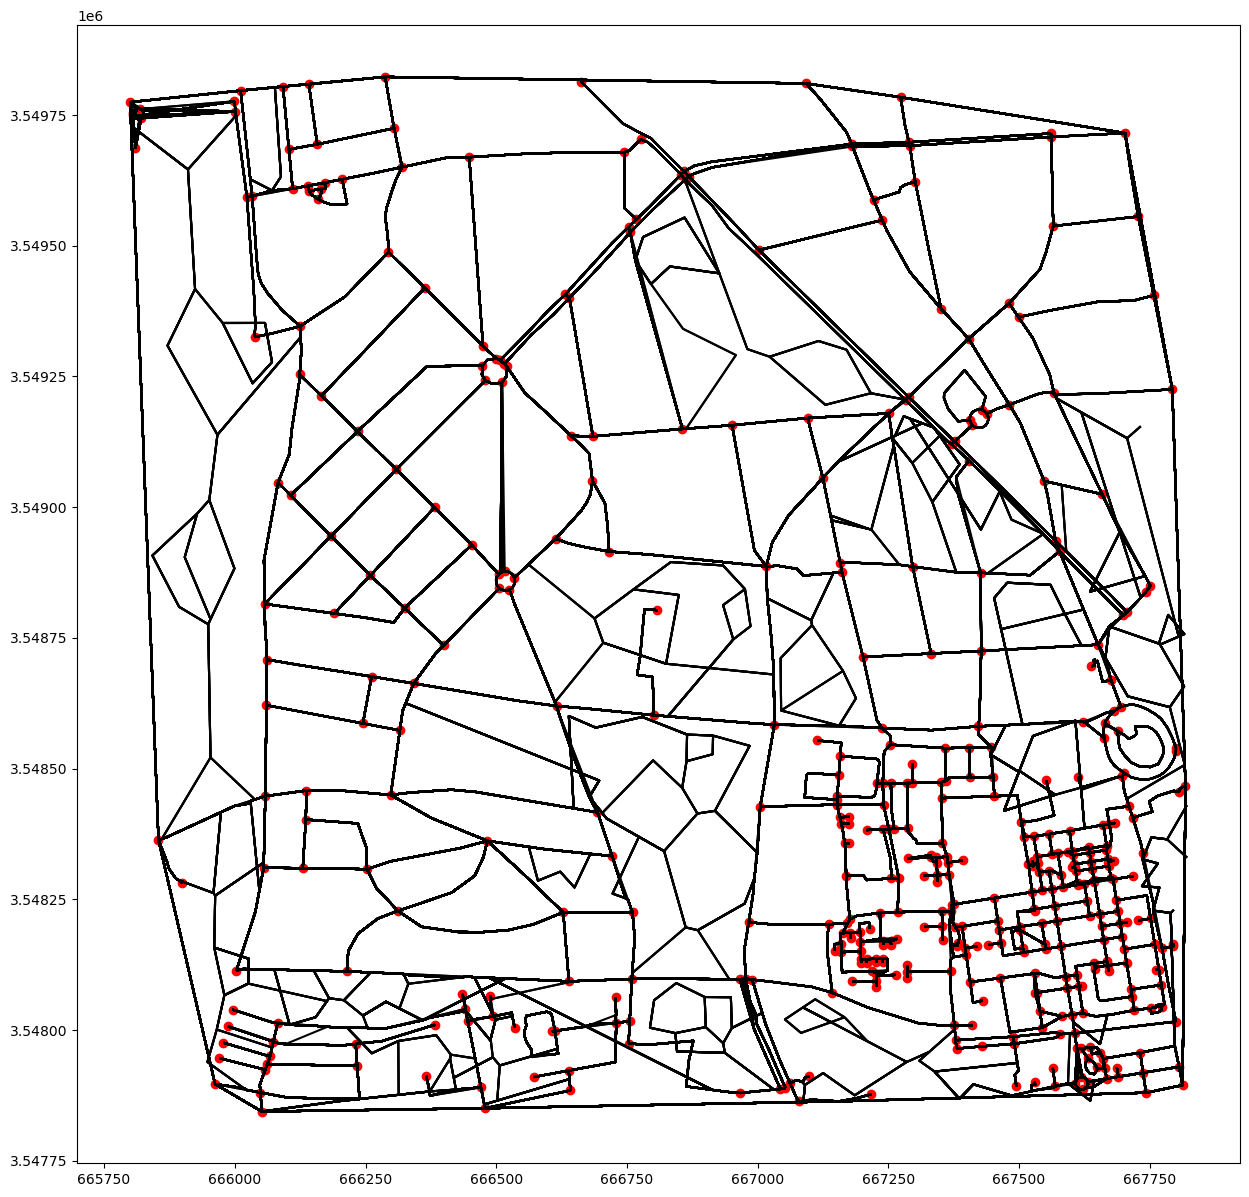

In [34]:
fig, ax = plt.subplots(figsize=(15, 15))
merged_gdf=gpd.GeoDataFrame(geometry=merged,crs=roads.crs)
# 使用空间最近邻匹配，给 merged_gdf 添加 label
merged_gdf = gpd.sjoin_nearest(merged_gdf, combined[["geometry", "label"]], how="left", distance_col="dist")
print(merged_gdf)
merged_gdf.plot(ax=ax, color="black",edgecolor="red")
roads.plot(ax=ax, color="black")
nodes.plot(ax=ax, color="red")

Index(['geometry', 'index_right', 'label', 'dist', 'mm_len', 'node_start',
       'node_end'],
      dtype='object')


<Axes: >

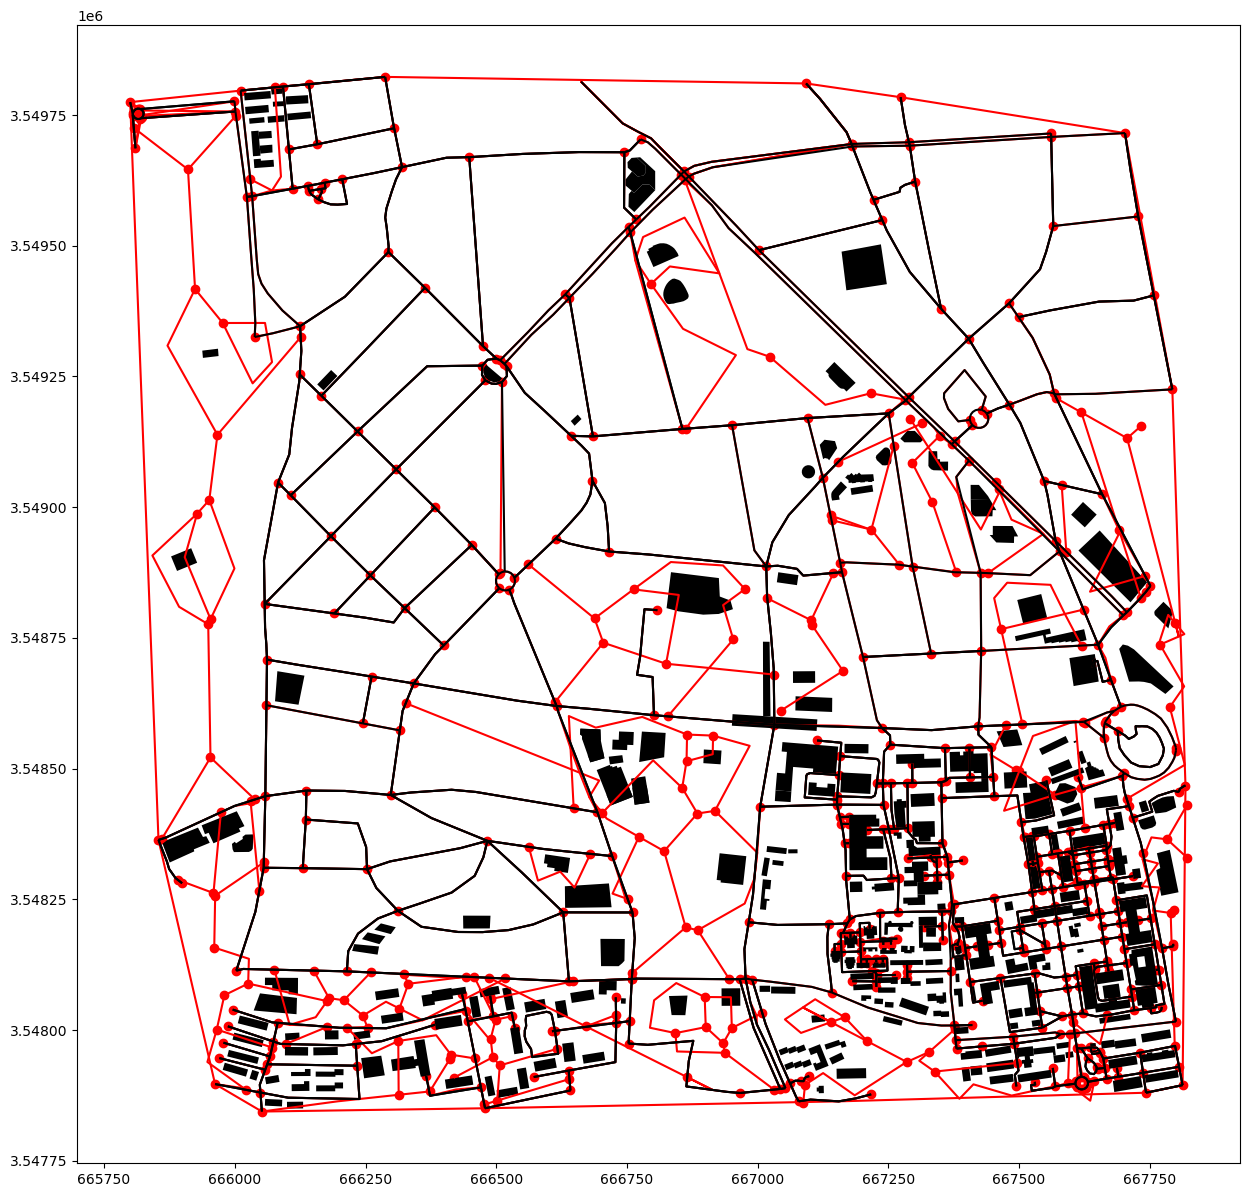

In [38]:
import momepy
import geopandas as gpd

# 1. 创建 networkx 图（这一步会自动打断线段）
G = momepy.gdf_to_nx(merged_gdf, approach='primal', multigraph=False)
# print(G)
# 2. 提取 edges 和 nodes 为 GeoDataFrame
# edges_gdf = momepy.nx_to_gdf(G, points=False)  # edges
nodes_gdf,edges_gdf= momepy.nx_to_gdf(G, points=True)   # nodes
fig, ax = plt.subplots(figsize=(15, 15))
edges_gdf.plot(ax=ax, color="red")
nodes_gdf .plot(ax=ax, color="red")
# closed.plot(ax=ax, color="orange")
roads.plot(ax=ax, color="black")
print(edges_gdf.columns)

# # 3. 保存为 shp（可选）
# edges_gdf.to_file("edges.shp")
# nodes_gdf.to_file("nodes.shp")
buildings_in_hull.plot(ax=ax,color="black")

In [41]:
edges_gdf.to_file("road_network_gen/Nanjing_Yihe/Nanjing_Yihe_edges.shp")
nodes_gdf.to_file("road_network_gen/Nanjing_Yihe/Nanjing_Yihe_nodes.shp")

C:\Users\Elena\AppData\Local\Temp\ipykernel_14392\1032194868.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_gdf.to_file("road_network_gen/Nanjing_Yihe/Nanjing_Yihe_edges.shp")
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
